In [2]:
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
from spyglass.common import (
    Session,
    IntervalList,
    Electrode,
    get_electrode_indices,
    interval_list_contains,
    interval_list_intersect,
)
from spyglass.lfp.v1 import LFPV1

# from spyglass.lfp_band.v1 import LFPBandV1
from spyglass.position import PositionOutput
from spyglass.position.v1 import TrodesPosV1
from tqdm import tqdm

import os

os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
from ms_opto_stim_protocol import (
    OptoStimProtocol,
    OptoStimProtocolParams,
    OptoStimProtocolTransfected,
    OptoStimProtocolLaser,
    OptoStimProtocolClosedLoop,
)
from Analysis.utils import filter_animal, filter_task, filter_opto_data
from Analysis.lfp_analysis import get_ref_electrode_index, power_spectrum
from Analysis.position_analysis import filter_position_ports
from Style.style_guide import transfection_style

os.chdir("/home/sambray/Documents/MS_analysis/")
from ms_task_performance import AlternationTaskPerformance
from ms_dio_event import DioEvents, ProcessedDioEvents

from ms_task_identification import TaskIdentification
from ms_interval import EpochIntervalListName

In [3]:
from spyglass.common import TaskEpoch

AlternationTaskPerformance()

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),previous_side_wells,previous_wells,current_wells,reward_outcomes,performance_outcomes
Banner20220224_.nwb,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
Banner20220224_.nwb,4,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
Banner20220224_.nwb,6,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
Banner20220224_.nwb,8,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
Banner20220224_.nwb,10,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
Banner20220224_.nwb,12,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
Banner20220224_.nwb,14,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
Banner20220224_.nwb,16,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
Banner20220225_.nwb,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
Banner20220225_.nwb,4,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


## Get data

In [4]:
track_type = "early_wtrack"
inbound_trial = []
trial_durations = []
opto_trial = []
transfected_trial = []
accuracy = []
animal = ""


#################################
for transfected in [True, False]:
    dataset_key = {
        # 'pulse_length_ms':40,
        # "transfected":True,
        "laser_power": 77,
        "targeted_phase": 90,
        "animal": animal,
        "transfected": transfected,
        "track_type": track_type,
        # "interval_list_name":"pos 3 valid times",
    }

    dataset = filter_opto_data(dataset_key)

    for nwb_file_name, interval_name in tqdm(
        zip(dataset.fetch("nwb_file_name"), dataset.fetch("interval_list_name"))
    ):
        key = {"nwb_file_name": nwb_file_name, "interval_list_name": interval_name}
        if nwb_file_name == "Winnie20220722_.nwb" and (
            interval_name == "pos 1 valid times" or interval_name == "pos 3 valid times"
        ):
            continue
        # outcomes and durations
        outcomes = ((AlternationTaskPerformance() * EpochIntervalListName) & key).fetch(
            "performance_outcomes"
        )[0]
        poke_times = (
            (ProcessedDioEvents().FirstUpPokes() * EpochIntervalListName) & key
        ).fetch1("dio_first_poke_times")
        last_poke_times = (
            (ProcessedDioEvents().LastDownPokes() * EpochIntervalListName) & key
        ).fetch1("dio_last_poke_times")
        # trial_durations.extend(np.diff(poke_times))
        inbound_trial.extend([("inbound" in x) for x in outcomes[1:]])
        accuracy.extend([("incorrect" in x) for x in outcomes[1:]])

        # durations
        travel_intervals = np.array(filter_position_ports(key))
        for i in range(poke_times.size - 1):
            travel_ = interval_list_intersect(
                np.array([[poke_times[i], poke_times[i + 1]]]), travel_intervals
            )
            trial_durations.append(
                np.sum([interval[1] - interval[0] for interval in travel_])
            )
        # trial_durations.extend(poke_times[1:]-last_poke_times[:poke_times.size-1])

        # Dio intervals
        test_intervals = (OptoStimProtocol() & key).fetch1("test_intervals")
        opto_trial.extend(
            [
                interval_list_contains(test_intervals, np.array([i])).size
                for i in poke_times[1:]
            ]
        )

        # transfected
        transfected_trial.extend(np.ones(outcomes.size - 1) * int(transfected))

trial_durations = np.array(trial_durations)
inbound_trial = np.array(inbound_trial)
opto_trial = np.array(opto_trial).astype(bool)
transfected_trial = np.array(transfected_trial).astype(bool)
accuracy = ~np.array(accuracy).astype(bool)


valid = trial_durations > 0
trial_durations = trial_durations[valid]
inbound_trial = inbound_trial[valid]
opto_trial = opto_trial[valid]
transfected_trial = transfected_trial[valid]
accuracy = accuracy[valid]

datasets: 44


44it [00:19,  2.21it/s]


datasets: 42


42it [00:21,  1.98it/s]


# New Plotting Arangement

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


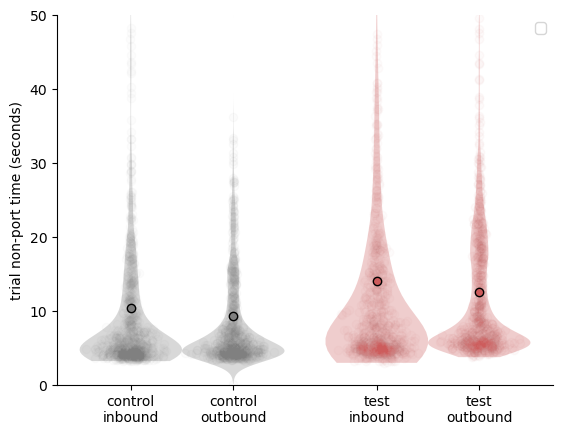

In [24]:
control_positions = np.array([0, 0.5])
test_positions = control_positions + 1.2

fig = plt.figure()
ax = fig.add_subplot(111)


control_sets = [
    trial_durations[inbound_trial & ~transfected_trial & opto_trial],
    trial_durations[~inbound_trial & ~transfected_trial & opto_trial],
]
test_sets = [
    trial_durations[inbound_trial & transfected_trial & opto_trial],
    trial_durations[~inbound_trial & transfected_trial & opto_trial],
]
from Analysis.utils import violin_scatter

bw = 0.1
for data, pos in zip(control_sets, control_positions):
    color = transfection_style["control"]
    violin_scatter(data, pos=pos, color=color, ax=ax, bw_method=bw)
    plt.scatter(pos, np.mean(data), color=color, edgecolors="k", lw=1)
for data, pos in zip(test_sets, test_positions):
    color = transfection_style["transfected"]
    violin_scatter(data, pos=pos, color=color, ax=ax, bw_method=bw)
    plt.scatter(pos, np.mean(data), color=color, edgecolors="k", lw=1)


plt.xticks(
    control_positions.tolist() + test_positions.tolist(),
    labels=[
        "control\ninbound",
        "control\noutbound",
        "test\ninbound",
        "test\noutbound",
    ],
)
plt.ylabel("trial non-port time (seconds)")
plt.ylim(0, 50)
plt.legend()
ax.spines[["top", "right"]].set_visible(False)
plt.rcParams["svg.fonttype"] = "none"
fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20241201/trial_duration.svg"
)

# Older Plotting arangements

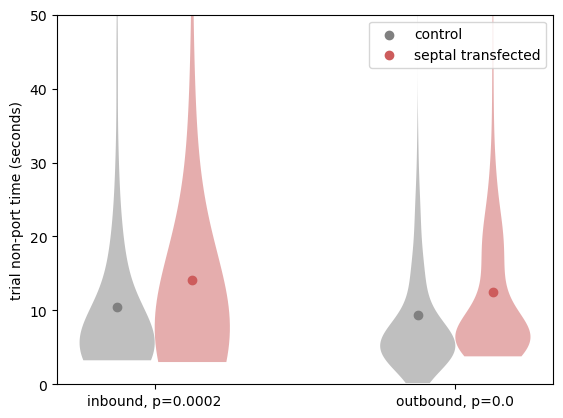

In [5]:
positions = np.array([0, 2])
# control = plt.violinplot([trial_durations[inbound_trial & ~transfected_trial& ~accuracy],
#                 trial_durations[~inbound_trial & ~transfected_trial& ~accuracy],],
#                positions = positions,
#                showmedians=False,showextrema=False,points=1000,)
# test = plt.violinplot([trial_durations[inbound_trial & transfected_trial& ~accuracy],
#                 trial_durations[~inbound_trial & transfected_trial& ~accuracy],],
#                positions = positions+.5,
#                showmeans=False,showextrema=False,points=1000,)
# plt.scatter(positions,[np.mean(trial_durations[inbound_trial & ~transfected_trial & ~accuracy]),
#                 np.mean(trial_durations[~inbound_trial & ~transfected_trial& ~accuracy]),],color = 'cornflowerblue',label='control')
# plt.scatter(positions+.5,[np.mean(trial_durations[inbound_trial & transfected_trial& ~accuracy]),
#                 np.mean(trial_durations[~inbound_trial & transfected_trial& ~accuracy]),],color = 'firebrick',label='septal transfected')


control_sets = [
    trial_durations[inbound_trial & ~transfected_trial & opto_trial],
    trial_durations[~inbound_trial & ~transfected_trial & opto_trial],
]
test_sets = [
    trial_durations[inbound_trial & transfected_trial & opto_trial],
    trial_durations[~inbound_trial & transfected_trial & opto_trial],
]
control = plt.violinplot(
    control_sets,
    positions=positions,
    showmedians=False,
    showextrema=False,
    points=1000,
)
test = plt.violinplot(
    test_sets,
    positions=positions + 0.5,
    showmeans=False,
    showextrema=False,
    points=1000,
)

plt.scatter(
    positions,
    [np.mean(x) for x in control_sets],
    color=transfection_style["control"],
    label="control",
)
plt.scatter(
    positions + 0.5,
    [np.mean(x) for x in test_sets],
    color=transfection_style["transfected"],
    label="septal transfected",
)

from scipy.stats import ttest_ind

inbound_p = ttest_ind(
    trial_durations[inbound_trial & ~transfected_trial],
    trial_durations[inbound_trial & transfected_trial],
    equal_var=False,
)[1]
outbound_p = ttest_ind(
    trial_durations[~inbound_trial & ~transfected_trial],
    trial_durations[~inbound_trial & transfected_trial],
    equal_var=False,
)[1]

for pc in control["bodies"]:
    pc.set_facecolor(transfection_style["control"])
    pc.set_alpha(0.5)
for pc in test["bodies"]:
    pc.set_facecolor(transfection_style["transfected"])
    pc.set_alpha(0.5)
plt.xticks(
    positions + 0.25,
    labels=[
        f"inbound, p={np.round(inbound_p,4)}",
        f"outbound, p={np.round(outbound_p,4)}",
    ],
)
plt.ylabel("trial non-port time (seconds)")
plt.ylim(0, 50)

plt.legend()

### Separate inbound trials by accuracy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


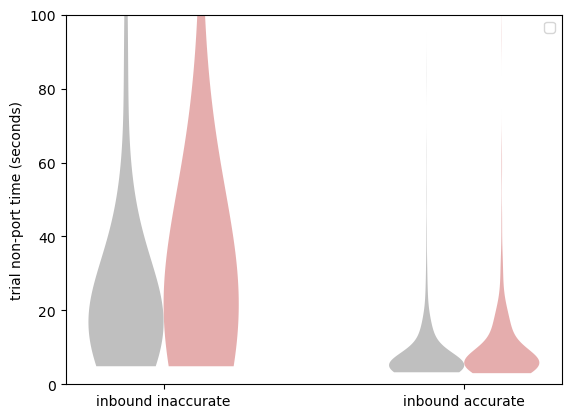

In [6]:
control = plt.violinplot(
    [
        trial_durations[inbound_trial & ~transfected_trial & ~accuracy],
        trial_durations[inbound_trial & ~transfected_trial & accuracy],
    ],
    positions=positions,
    showmedians=False,
    showextrema=False,
    points=1000,
)
test = plt.violinplot(
    [
        trial_durations[inbound_trial & transfected_trial & ~accuracy],
        trial_durations[inbound_trial & transfected_trial & accuracy],
    ],
    positions=positions + 0.5,
    showmeans=False,
    showextrema=False,
    points=1000,
)


for pc in control["bodies"]:
    pc.set_facecolor(transfection_style["control"])
    pc.set_alpha(0.5)
for pc in test["bodies"]:
    pc.set_facecolor(transfection_style["transfected"])
    pc.set_alpha(0.5)

plt.ylim(0, 100)
plt.xticks(positions + 0.25, labels=["inbound inaccurate", "inbound accurate"])
plt.ylabel("trial non-port time (seconds)")
plt.ylim(0, 100)

plt.legend()

(0.0, 110.0)

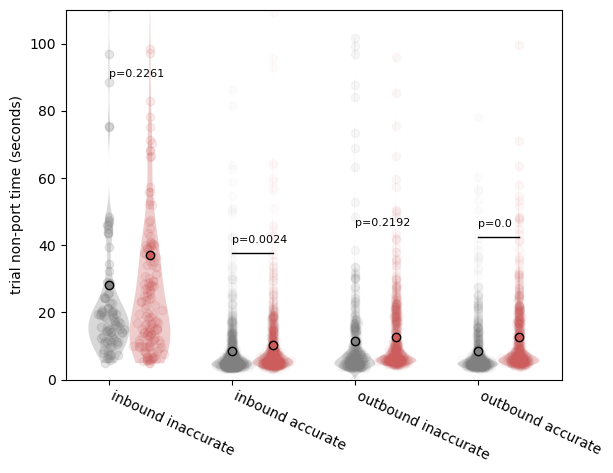

In [7]:
from Analysis.utils import violin_scatter
from Style.style_guide import transfection_style
from scipy.stats import ttest_ind

fig = plt.figure()
for i, trial_type in enumerate(["inbound", "outbound"]):
    if trial_type == "inbound":
        trials = inbound_trial
    else:
        trials = ~inbound_trial

    inaccurate_control = trial_durations[trials & ~transfected_trial & ~accuracy]
    accurate_control = trial_durations[trials & ~transfected_trial & accuracy]
    inaccurate_test = trial_durations[trials & transfected_trial & ~accuracy]
    accurate_test = trial_durations[trials & transfected_trial & accuracy]

    shift = 3 * i
    violin_scatter(
        inaccurate_control,
        pos=shift,
        color=transfection_style["control"],
        # mark_mean=True,
        bw_method=0.1,
    )
    plt.scatter(
        [shift],
        [np.mean(inaccurate_control)],
        facecolor=transfection_style["control"],
        edgecolors="k",
    )
    violin_scatter(
        inaccurate_test,
        pos=shift + 0.5,
        color=transfection_style["transfected"],
        # mark_mean=True,
        bw_method=0.1,
    )
    plt.scatter(
        [shift + 0.5],
        [np.mean(inaccurate_test)],
        facecolor=transfection_style["transfected"],
        edgecolors="k",
    )
    violin_scatter(
        accurate_control,
        pos=shift + 1.5,
        color=transfection_style["control"],
        # mark_mean=True,
        bw_method=0.1,
    )
    plt.scatter(
        [shift + 1.5],
        [np.mean(accurate_control)],
        facecolor=transfection_style["control"],
        edgecolors="k",
    )
    violin_scatter(
        accurate_test,
        pos=shift + 2,
        color=transfection_style["transfected"],
        # mark_mean=True,
        bw_method=0.1,
    )
    plt.scatter(
        [shift + 2],
        [np.mean(accurate_test)],
        facecolor=transfection_style["transfected"],
        edgecolors="k",
    )

    # t-test
    p_inaccurate = ttest_ind(inaccurate_control, inaccurate_test, equal_var=False)[1]
    loc = np.max([inaccurate_control.mean(), inaccurate_test.mean()]) * 2 + 20
    plt.text(shift, min(loc, 90), f"p={np.round(p_inaccurate, 4)}", fontsize=8)

    p_accurate = ttest_ind(accurate_control, accurate_test, equal_var=False)[1]
    loc = np.max([accurate_control.mean(), accurate_test.mean()]) * 2 + 20
    plt.text(shift + 1.5, min(loc, 90), f"p={np.round(p_accurate, 4)}", fontsize=8)
    if p_accurate < 0.05:
        plt.plot([shift + 1.5, shift + 2], [loc - 3, loc - 3], color="k", linewidth=1)

plt.ylim(0, 100)
plt.xticks(
    [0, 1.5, 3, 4.5],
    labels=[
        "inbound inaccurate",
        "inbound accurate",
        "outbound inaccurate",
        "outbound accurate",
    ],
    rotation=-25,
    ha="left",
)
plt.ylabel("trial non-port time (seconds)")
plt.ylim(0, 110)

In [15]:
plt.rcParams["svg.fonttype"] = "none"
# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Plots/fens_2024/trial_durations.svg",
#     format="svg",
# )
fig.savefig(
    "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20241201/wtrack_trial_durations.svg",
    format="svg",
)

In [ ]:
import os

# os.listdir(".")
os.curdir

'.'

In [145]:
from scipy.stats import ttest_ind

inbound_p = ttest_ind(
    trial_durations[inbound_trial & ~transfected_trial],
    trial_durations[inbound_trial & transfected_trial],
    equal_var=False,
)[1]

outbound_p = ttest_ind(
    trial_durations[~inbound_trial & ~transfected_trial],
    trial_durations[~inbound_trial & transfected_trial],
    equal_var=False,
)[1]

0.23801773745361235

## Define Trial by running times

In [24]:
animal = "Winnie"
track_type = "wtrack"
dataset_key = {
    # 'pulse_length_ms':40,
    # "transfected":True,
    "laser_power": 77,
    "targeted_phase": 90,
    "animal": animal,
}

dataset = (
    OptoStimProtocol
    * OptoStimProtocolTransfected
    * OptoStimProtocolLaser
    * OptoStimProtocolClosedLoop
) & dataset_key

dataset = filter_animal(dataset, dataset_key["animal"])
dataset = filter_task(dataset, track_type)

inbound_trial = []
trial_durations = []
opto_trial = []
for nwb_file_name, interval_name in zip(
    dataset.fetch("nwb_file_name"), dataset.fetch("interval_list_name")
):
    key = {"nwb_file_name": nwb_file_name, "interval_list_name": interval_name}

    break
interval = (IntervalList & key).fetch1("valid_times")
travel_intervals = np.array(filter_position_ports(key))

In [25]:
travel_durations = np.array(
    [interval[1] - interval[0] for interval in travel_intervals]
)
ind = np.where(travel_durations > 5)[0]
travel_durations = travel_durations[ind]
travel_intervals = travel_intervals[ind]

In [26]:
travel_durations

array([ 5.28599644, 27.58598161, 15.26398993, 43.7739706 , 68.00395441,
       19.40198708, 10.53399301, 29.49798036, 30.51197958,  6.88599539,
       29.72598004, 22.21598506,  8.68599415, 25.64998293, 40.86797261,
       15.99798918, 35.42797637,  5.74799609, 42.76197124, 21.51998568,
       31.31197906, 54.14796376, 25.56798291, 45.10396957, 31.19597912,
       34.20197725, 41.86597204, 41.87597179, 73.38995099, 21.1879859 ,
       16.30198908, 27.82198119,  5.56599617])